# Run the speciation model with fastscape

In [1]:
import numpy as np
import pandas as pd
import xsimlab as xs
import matplotlib.pyplot as plt

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

from fastscape.models import basic_model
from fastscape.processes import MultipleFlowRouter

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from paraspec.fastscape_ext import IR12Speciation, IR12EnvironmentElevation

## Speciation without competition in an evolving landscape

In [2]:
model = basic_model.update_processes({
    'life_env': IR12EnvironmentElevation,
    'life': IR12Speciation,
    'flow': MultipleFlowRouter
})

model

<xsimlab.Model (18 processes, 19 inputs)>
grid
    shape              [in] ('shape_yx',) nb. of grid nodes in (y, x)
    length             [in] ('shape_yx',) total grid length in (y, x)
boundary
    status             [in] () or ('border',) node status at borders
fs_context
uplift
    rate               [in] () or ('y', 'x') uplift rate
tectonics
init_topography
    seed               [in] random seed
surf2erode
flow
    slope_exp          [in] () or ('y', 'x') MFD partioner slope ex...
drainage
spl
    k_coef             [in] () or ('y', 'x') bedrock channel incisi...
    area_exp           [in] drainage area exponent
    slope_exp          [in] slope exponent
init_erosion
diffusion
    diffusivity        [in] () or ('y', 'x') diffusivity (transport...
erosion
vmotion
topography
terrain
life_env
life
    init_size          [in] initial population size
    init_min_trait     [in] initial min trait value
    init_max_trait     [in] initial max trait value
    random_seed        [in] ra

In [3]:
in_ds = xs.create_setup(
    model=model,
    clocks={
        'time': np.linspace(0., 1e6, 1001),
        'out': np.linspace(0., 1e6, 101)
    },
    master_clock='time',
    input_vars={
        'grid__shape': [201, 201],
        'grid__length': [2e4, 2e4],
        'boundary__status': ['looped', 'looped', 'fixed_value', 'fixed_value'],
        'uplift__rate': 1e-3,
        'flow__slope_exp': 1.,
        'spl__k_coef': 1e-4,
        'diffusion__diffusivity': 1e-3,
        'life': {
            'init_size': 100,
            'init_min_trait': 0.5, #0,
            'init_max_trait': 0.5, #100,
            'nb_radius': 1e3,
            'capacity': 15,
            'sigma_d': 100.,
            'sigma_mut': 0.05, #25,
            'sigma_w': 0.2, #50,
            'random_seed': 1234
        }
    },
    output_vars={
        'topography__elevation': 'out',
        'drainage__area': 'out',
        'life__x': 'out',
        'life__y': 'out',
        'life__opt_trait': 'out',
        'life__trait': 'out',
        'life__parent': 'out',
        'life__id': 'out'
    }
)

In [4]:
with xs.monitoring.ProgressBar():
    out_ds = in_ds.xsimlab.run(model=model)

             0% | initialize 

In [5]:
df = (
    out_ds
    # only keep paraspec output variables
    .drop_dims([d for d in out_ds.dims if d not in ('out', 'pop')])
    .drop_vars(in_ds, errors='ignore')
    # convert to a dataframe
    # see https://xarray-simlab.readthedocs.io/en/latest/io_storage.html#dynamically-sized-arrays
    .stack(fpop=('out', 'pop'))
    .dropna('fpop', how='all')
    .to_dataframe()
    # clean
    .rename(columns=lambda name: name.replace('life__', ''))
    .reset_index()
    .dropna()
    .set_index('id', drop=False)
    # assign tree-specific extra columns
    .assign(
        tree_id=lambda df: df.ptree.tree_id,
        node_type=lambda df: df.ptree.node_type
    )
)


df

,out,pop,id,opt_trait,parent,trait,x,y,tree_id,node_type
id,,,,,,,,,,
1.0,0.0,1,1.0,0.169926,1.0,0.500000,7603.914700,12383.220327,1.0,root
2.0,0.0,2,2.0,0.307148,2.0,0.500000,18464.924675,6035.148592,2.0,root
3.0,0.0,3,3.0,0.926820,3.0,0.500000,5233.848477,3496.929023,3.0,root
4.0,0.0,4,4.0,0.502955,4.0,0.500000,6381.941168,9910.103904,4.0,root
5.0,0.0,5,5.0,0.519775,5.0,0.500000,2361.824659,15211.408005,5.0,root
...,...,...,...,...,...,...,...,...,...,...
1725494.0,990000.0,1761,1725494.0,0.382342,1707714.0,0.416313,15.903883,4699.104081,99.0,leaf
1725495.0,990000.0,1762,1725495.0,0.521276,1707715.0,0.229766,463.746566,4879.780644,99.0,leaf
1725496.0,990000.0,1763,1725496.0,0.583431,1707717.0,0.432310,571.677775,5237.202469,99.0,leaf


## Plot population

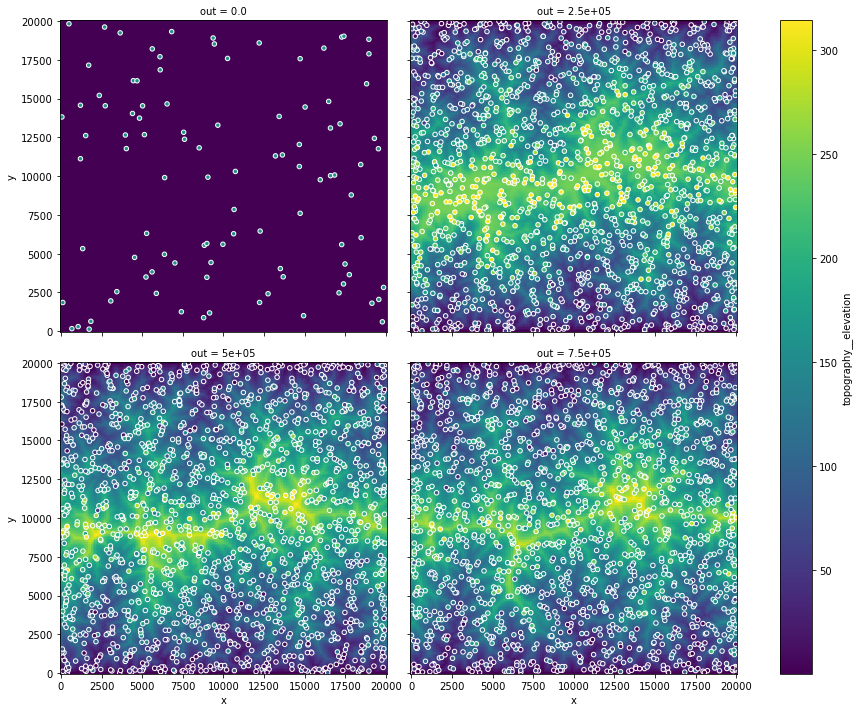

In [6]:
times = np.arange(0, 1e6, 2.5e5)
elev_max = out_ds.topography__elevation.max()


fg = (out_ds
      .sel(out=times)
      .topography__elevation.plot(col='out', col_wrap=2, figsize=(13, 10)))


for ax, t in zip(fg.axes.ravel(), times):
    pop = df[df.out==t]
    ax.scatter(pop.x, pop.y, c=pop.trait, vmin=0, vmax=1, s=20, edgecolor='w')

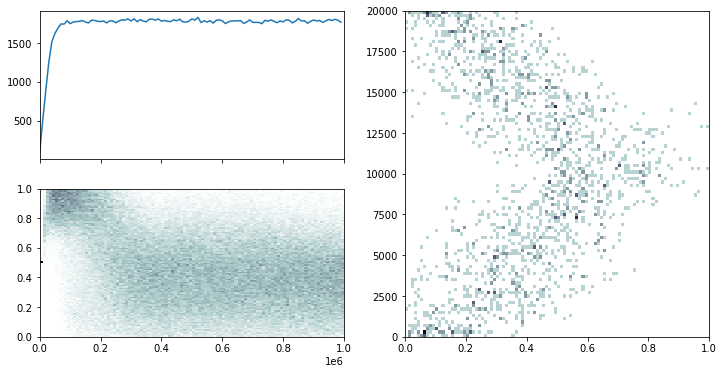

In [7]:
fig2, axs2 = plt.subplots(2, 2, sharex="col", figsize=(12, 6))
gs2 = axs2[1, 1].get_gridspec()
for ax in axs2[0:, -1]:
    ax.remove()
axbig = fig2.add_subplot(gs2[0:, -1])
axs2[0,0].plot(df.groupby('out').size())
h,xedge,yedge,_=axs2[1,0].hist2d(x=df['out'], y=df['trait'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axbig.hist2d(x=df['trait'].loc[df['out']==max(df['out'])], 
                             y=df['y'].loc[df['out']==max(df['out'])], 
                                 range=((0, 1), (0, 20000)), 
                                 bins=(100, 100), cmap='bone_r')

## Plot subtree 

In [8]:
def plot_tree(G, pos=None, root=None, alpha=0.5, node_size=40,
              node_color='trait', cmap=plt.cm.viridis,
              edge_color=None, edge_cmap=plt.cm.gray,
              vmin=None, vmax=None, prog='dot', ax='none', fig='none'):

    if pos is None:
        pos = graphviz_layout(G, prog=prog, root=root)
    else:
        x, y = pos
        pos = {k: (v[x], v[y]) for k, v in G.nodes.data()}

    node_data = [n.get(node_color) for n in G.nodes.values()]
    if vmin is None:
        vmin = np.nanmin(node_data)
    if vmax is None:
        vmax = np.nanmax(node_data)

    if edge_color is None:
        edge_data = 'k'
    else:
        edge_data = [e.get(edge_color) for e in G.edges.values()]

    if ax=='none':
        fig, ax = plt.subplots(figsize=(14, 12))


    nx.draw(G, pos=pos, ax=ax, alpha=alpha,
            node_size=node_size, node_color=node_data,
            cmap=cmap, vmin=vmin, vmax=vmax,
            edge_color=edge_data, edge_cmap=edge_cmap)

    sm = plt.cm.ScalarMappable(cmap=cmap,
                               norm=plt.Normalize(vmin=vmin, vmax=vmax))

    sm.set_array([])
    
    cbar = plt.colorbar(sm, fraction=0.025, pad=0.04)

    return fig, ax

In [9]:
tree_id = df.tree_id.value_counts().idxmax()  # find root with largest tree
leaf = df[(df.tree_id==tree_id) & (df.out==df.out.max())].id  # end nodes (leaf) of tree_id

# define subtree (dataframe and networkx)
df_tree = (
    df
    .ptree.merge_forest(-1)
    .ptree.drop_disconnected_roots()
    .ptree.extract_subtree(leaf=list(leaf))
)

G = df_tree.ptree.to_networkx(node_col='trait')

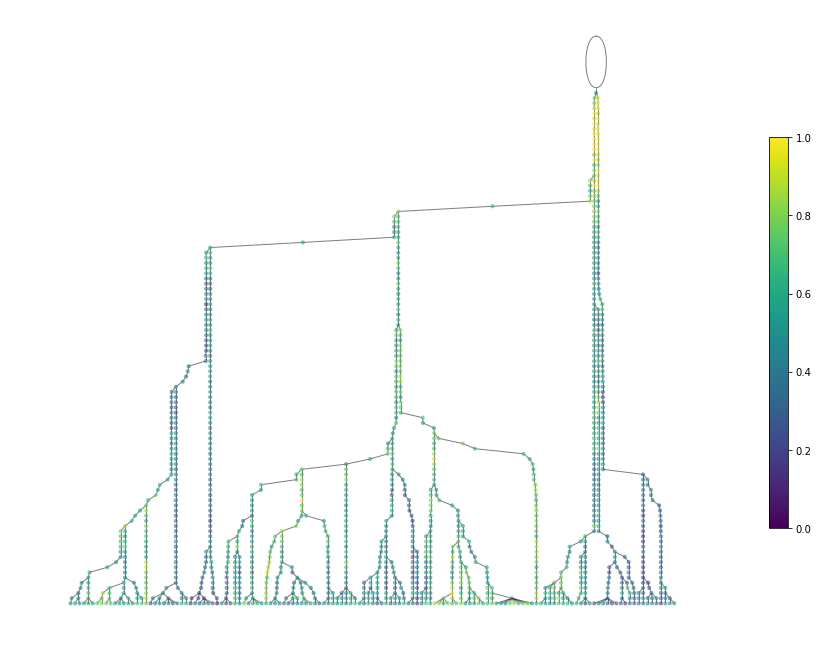

In [10]:
plot_tree(G, prog='dot', node_color='trait', node_size=10, cmap=plt.cm.viridis,
          vmin=0, vmax=1);

## Speciation with competition in an evolving landscape

In [11]:
from paraspec.fastscape_ext import DD03Speciation, DD03EnvironmentElevation

In [12]:
model2 = basic_model.update_processes({
    'life_env': DD03EnvironmentElevation,
    'life': DD03Speciation,
    'flow': MultipleFlowRouter
})
model2

<xsimlab.Model (18 processes, 24 inputs)>
grid
    shape                [in] ('shape_yx',) nb. of grid nodes in (y...
    length               [in] ('shape_yx',) total grid length in (y...
boundary
    status               [in] () or ('border',) node status at borders
fs_context
uplift
    rate                 [in] () or ('y', 'x') uplift rate
tectonics
init_topography
    seed                 [in] random seed
surf2erode
flow
    slope_exp            [in] () or ('y', 'x') MFD partioner slope ...
drainage
spl
    k_coef               [in] () or ('y', 'x') bedrock channel inci...
    area_exp             [in] drainage area exponent
    slope_exp            [in] slope exponent
init_erosion
diffusion
    diffusivity          [in] () or ('y', 'x') diffusivity (transpo...
erosion
vmotion
topography
terrain
life_env
life
    init_size            [in] initial population size
    init_min_trait       [in] initial min trait value
    init_max_trait       [in] initial max trait value
    random_s

In [13]:
in_ds2 = xs.create_setup(
    model=model2,
    clocks={
        'time': np.linspace(0., 1e6, 1001),
        'out': np.linspace(0., 1e6, 101)
    },
    master_clock='time',
    input_vars={
        'grid__shape': [201, 201],
        'grid__length': [2e4, 2e4],
        'boundary__status': ['looped', 'looped', 'fixed_value', 'fixed_value'],
        'uplift__rate': 1e-3,
        'flow__slope_exp': 1.,
        'spl__k_coef': 1e-4,
        'diffusion__diffusivity': 1e-3,
        'life': {
            'init_size': 100,
            'init_min_trait': 0.5,
            'init_max_trait': 0.5,
            'birth_rate': 1.,
            'movement_rate': 5.,
            'slope_topt_env': 0.95,
            'car_cap_max': 1000.,
            'sigma_opt_trait': 0.2,
            'mut_prob': 0.05,
            'sigma_mut': 0.05,
            'sigma_mov': 100.,
            'sigma_comp_trait': 0.9,
            'sigma_comp_dist': 0.2,
            'random_seed': 1234
        }
    },
    output_vars={
        'topography__elevation': 'out',
        'drainage__area': 'out',
        'life__x': 'out',
        'life__y': 'out',
        'life__trait': 'out',
        'life__parent': 'out',
        'life__id': 'out'
    }
)

In [14]:
with xs.monitoring.ProgressBar():
    out_ds2 = in_ds2.xsimlab.run(model=model2)

             0% | initialize 

In [15]:
df2 = (
    out_ds2
    # only keep paraspec output variables
    .drop_dims([d for d in out_ds2.dims if d not in ('out', 'pop')])
    .drop_vars(in_ds2, errors='ignore')
    # convert to a dataframe
    # see https://xarray-simlab.readthedocs.io/en/latest/io_storage.html#dynamically-sized-arrays
    .stack(fpop=('out', 'pop'))
    .dropna('fpop', how='all')
    .to_dataframe()
    # clean
    .rename(columns=lambda name: name.replace('life__', ''))
    .reset_index()
    .dropna()
    .set_index('id', drop=False)
    # assign tree-specific extra columns
    #.assign(
    #    tree_id=lambda df: df.ptree.tree_id,
    #    node_type=lambda df: df.ptree.node_type
    #)
)


df2

,out,pop,id,parent,trait,x,y
id,,,,,,,
1.0,0.0,1,1.0,1.0,0.500000,7709.264145,12496.751206
2.0,0.0,2,2.0,2.0,0.500000,18338.808851,6050.465001
3.0,0.0,3,3.0,3.0,0.500000,5193.375055,3600.590468
4.0,0.0,4,4.0,4.0,0.500000,6334.689902,9649.457938
5.0,0.0,5,5.0,5.0,0.500000,2299.582170,15180.010961
...,...,...,...,...,...,...,...
177203.0,1000000.0,1686,177203.0,176942.0,0.197652,18920.784488,19381.396123
177204.0,1000000.0,1687,177204.0,176955.0,0.279213,1877.526397,18818.078624
177205.0,1000000.0,1688,177205.0,176959.0,0.180572,9497.793961,839.192665


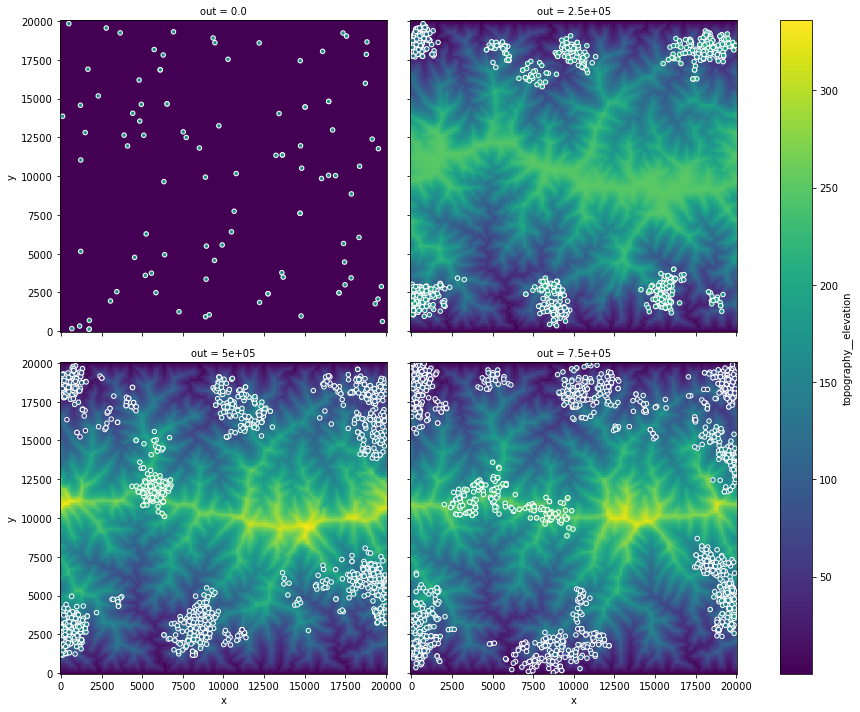

In [16]:
times = np.arange(0, 1e6, 2.5e5)
elev_max = out_ds2.topography__elevation.max()


fg = (out_ds2
      .sel(out=times)
      .topography__elevation.plot(col='out', col_wrap=2, figsize=(13, 10)))


for ax, t in zip(fg.axes.ravel(), times):
    pop = df2[df2.out==t]
    ax.scatter(pop.x, pop.y, c=pop.trait, vmin=0, vmax=1, s=20, edgecolor='w')

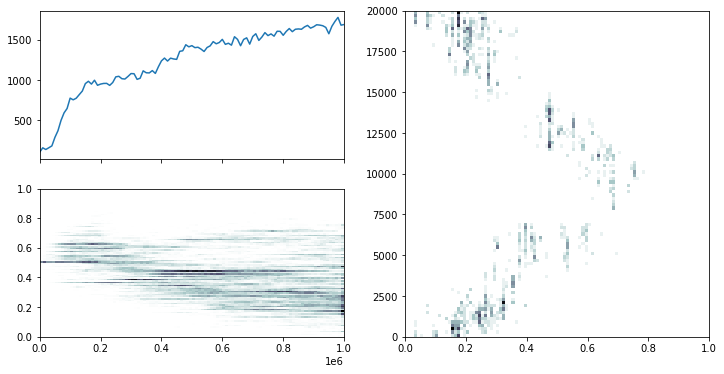

In [17]:
fig5, axs5 = plt.subplots(2, 2, sharex="col", figsize=(12, 6))
gs5 = axs5[1, 1].get_gridspec()
for ax in axs5[0:, -1]:
    ax.remove()
axbig = fig5.add_subplot(gs5[0:, -1])
axs5[0,0].plot(df2.groupby('out').size())
h,xedge,yedge,_=axs5[1,0].hist2d(x=df2['out'], y=df2['trait'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axbig.hist2d(x=df2['trait'].loc[df2['out']==max(df2['out'])], 
                             y=df2['y'].loc[df2['out']==max(df2['out'])], 
                                 range=((0, 1), (0, 20000)), 
                                 bins=(100, 100), cmap='bone_r')